# 3. 分类

## MNIST

In [1]:
from sklearn.datasets import fetch_openml
# load data from https://www.openml.org/d/554
mnist = fetch_openml('mnist_784', version=1)
mnist

{&#39;data&#39;: array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 &#39;target&#39;: array([&#39;5&#39;, &#39;0&#39;, &#39;4&#39;, ..., &#39;4&#39;, &#39;5&#39;, &#39;6&#39;], dtype=object),
 &#39;frame&#39;: None,
 &#39;categories&#39;: {},
 &#39;feature_names&#39;: [&#39;pixel1&#39;,
  &#39;pixel2&#39;,
  &#39;pixel3&#39;,
  &#39;pixel4&#39;,
  &#39;pixel5&#39;,
  &#39;pixel6&#39;,
  &#39;pixel7&#39;,
  &#39;pixel8&#39;,
  &#39;pixel9&#39;,
  &#39;pixel10&#39;,
  &#39;pixel11&#39;,
  &#39;pixel12&#39;,
  &#39;pixel13&#39;,
  &#39;pixel14&#39;,
  &#39;pixel15&#39;,
  &#39;pixel16&#39;,
  &#39;pixel17&#39;,
  &#39;pixel18&#39;,
  &#39;pixel19&#39;,
  &#39;pixel20&#39;,
  &#39;pixel21&#39;,
  &#39;pixel22&#39;,
  &#39;pixel23&#39;,
  &#39;pixel24&#39;,
  &#39;pixel25&#39;,
  &#39;pixel26&#39

Scikit-Learn加载的数据集通常具有类似的字典结构，包括：
- DESCR键，描述数据集
- data键，包含一个数组，每个实例为一行，每个特征为一列
- target键，包含一个带有标记的数组

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

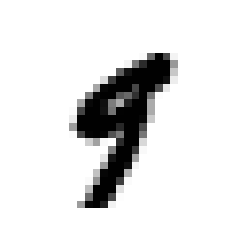

In [4]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

&#39;9&#39;

事实上MNIST数据集已经分成了测试集（前60000张图像）和测试集（最后10000张图像）

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

我们都对训练集进行数据洗牌，这样才能保证交叉验证时所有的折叠都差不多。此外，有些机器学习算法对训练实例的顺序敏感，如果连续输入许多相似的实例，可能导致执行性能不佳。

In [7]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二元分类器

先简化问题，只尝试训练一个数字——9

In [8]:
y_train_9 = (y_train == '9')
y_test_9 = (y_test == '9')
y_train_9 = y_train_9.astype(np.uint8)
y_test_9 = y_test_9.astype(np.uint8)

y_train_9, y_test_9

(array([0, 0, 1, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8))

SGDClassifier分类器，能够有效处理非常大型的数据集。这部分是因为SGD独立处理训练实例，一次一个，这也使得SGD非常适合在线学习。

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(random_state=42)

SGDClassifier在训练时是完全随机的，如果希望可以得到可复现的结果，需要设置参数random_state

In [10]:
sgd_clf.predict([some_digit]), sgd_clf.predict([X_train[5]])

(array([0], dtype=uint8), array([0], dtype=uint8))

这里面有预测错误的，也有预测成功的，下面我们计算一个预测的precision

In [11]:
y_pred = sgd_clf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [12]:
np.sum(y_pred == y_test_9)/len(y_test_9)

0.9556

可以看到模型的预测的precision为94.06%，表面上看起来还不赖

### 性能考核
#### 使用交叉验证测量精度

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_9):
    # print(train_index, train_index.shape, test_index, test_index.shape)
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_9[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_9[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = np.sum(y_pred == y_test_fold)
    print(n_correct/len(y_test_fold))

0.9389166666666666
0.9518333333333333
0.9514166666666667
0.9478333333333333
0.9223333333333333


也可以使用cross_val_score进行交叉验证

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.93995, 0.88745, 0.94305])

从上面可以看到所有的交叉验证的准确率都达到了94%！在激动之前我们可以看看一个笨重的分类器

In [15]:
from sklearn.base import BaseEstimator
class Never9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1))

In [16]:
never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.90115, 0.8981 , 0.9033 ])

上面的分类器把所有的数字都预测为非9的，但是依然可以达到90%的准确率，这是由于**偏斜数据集造成的**

#### 混淆矩阵

要计算混淆矩阵，需要先有一组预测才能将其与实际目标进行比较，当然可以通过测试集来进行测试，倒是现在先不要动它（**测试集最好留到项目最后，准备启动分类器时在使用**），作为替代，可以使用`cross_val_predict()`函数

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)
y_train_predict, y_train_predict.shape

(array([0, 0, 1, ..., 0, 0, 0], dtype=uint8), (60000,))

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_predict)

array([[51200,  2851],
       [ 1740,  4209]])

本示例中第一行表示所有“非9”（负类-Negative）的图像中：52767张被正确的分为“非9”类别（真负类-TN），1284张错误地分类成了“9”（假正类-FP）；第二行表示所有的“9”（正类-Positive）的图像中：1879张被错误的分为了“非9”类别（假负类-FN），4070张被正确地分在了“9”这个类（真正类-TP）。一个完美的分类器只有真真正类和真负类，所以他的混淆矩阵只会在其对角线（左上到右下）上有非零值

In [19]:
y_train_perfect_predictions = y_train_9
confusion_matrix(y_train_9, y_train_perfect_predictions)

array([[54051,     0],
       [    0,  5949]])

#### 精度-Precision

[Google解释](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=zh-cn)

**Precision尝试回答的问题：在被识别为正类别的样本中，确实为正类别的比例是多少？**

$$
Precision = \frac{TP}{TP+FP}
$$

做一个单独的正类预测，并确保它是正确的，就可以得到完美的精度（precision=1/1=100%）。但是这没有什么意义，因为分类器会忽略掉这个正类实例之外的所有内容。因此Accuracy通常与召回率-Recall，也称为灵敏度-Sensitivity或者真正率-TPR一起使用：

**Recall尝试回答的问题：在所有正类别样本中，被正确识别为正类别的比例是多少？**


$$
Recall = \frac{TP}{TP+FN}
$$

![confusion_matrix](./images/confusion_matrix.png)

**注意，Precision与Accuracy千万不要弄混了**

$$
Accuracy = \frac{TP + TN}{TP + FP + TN + FN}
$$


1. 一般来说，提高分类阈值会减少假正类-TP，从而提高Precision
2. 提高分类阈值会导致真正类-TP的减少或不变，同时假负类-FN的值会增加或保持不变。因此召回率保持不变或下降
3. 一般来说，如果某个模型在精确率和召回率方面均优于另一模型，则该模型可能更好。很显然，我们需要确保在精确率/召回率点处进行比较，这在实践中非常有用，因为这样做才有实际意义。例如，假设我们的垃圾邮件检测模型需要达到至少 90% 的精确率才算有用，并可以避免不必要的虚假警报。在这种情况下，将 {20% 精确率，99% 召回率} 模型与另一个 {15% 精确率，98% 召回率} 模型进行比较不是特别有意义，因为这两个模型都不符合 90% 的精确率要求。但考虑到这一点，在通过精确率和召回率比较模型时，这是一种很好的方式。

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_9, y_train_predict)

0.5961756373937677

In [22]:
recall_score(y_train_9, y_train_predict)

0.7075138678769541

我们可以很方便地将精度和召回率组合成一个单一的指标，称为$F_1$分数。$F_1$分数是精度和召回率的谐波平均值。**正常的平均值平等对待所有的值，而谐波平均值会给予较低的值更高的权重。因此，只有当召回率和精度都很高时，分类器才能得到较高的$F_1$分数。**

$$
F_1 = \frac{2}{\frac{1}{Accuracy} + \frac{1}{Recall}} = 2 \times \frac{Accuracy \times Recall}{Accuracy + Recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$


In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_predict)

0.6470904758244292

$F_1$分数对那些具有相似的精度和召回率的分类器更为有利。这不一定能一直符合你的期望：在某些情况下，你更关心的是精度，而另一些情况下，你可能真正关心的是召回率。例如，假设你训练一个分类器来检测儿童可以放心看的视频，那么你可能更青睐那种拦截了很多好视频（低召回率），但是保留下来的视频都是安全（高精度）的分类器，而不是Recall虽高，但是在产品中可能会出现一些非常糟糕的视频的分类器（这种情况下，你甚至可能会增加一个工人流水线来检查分类器选出来的视频）。反过来说，如果你训练一个分类器通过图像监控来检测小偷：你大概可以接受精度只有30%，只要召回率能达到99%（当然，安保人员会收到一些错误的警报，但是几乎所有的窃贼都在劫难逃）。

**遗憾的是，鱼和熊掌不可兼得：你不能同时增加精度并减少召回率，反之亦然，这称为精度/召回率权衡。**

### Precision/Recall权衡
要理解这个权衡过程，我们来看看SGDClassifier如何进行分类决策。对于每个实例，他会给予决策函数计算出一个分值，如果该值大于阈值，则将该实例判为正类，否则便将其判为负类。Scikit-Learn不允许直接设置阈值，但是可以访问它用于预测的决策分数。不是调用分类器的`predict()`方法，而是调用`decision_function()`方法，这个方法返回每个实例的分数，然后就可以根据这些分数，使用任意阈值进行预测了

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-4710.31909378])

In [25]:
threshold = -5000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

### 如何决定使用什么阈值呢？
#### 1. 首先使用cross_val_predict()函数获取训练集中所有实例的分数，但是这次需要它返回的是决策分数而不是预测结果

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method="decision_function")
y_scores

array([-38805.11193315, -26680.86068743,   1351.50729744, ...,
       -14451.53682289, -64515.898079  ,  -5878.80919097])

#### 2. 有了这些分数，可以使用`precision_recall_curve()`函数计算所有可能的阈值的精度和召回率：

In [28]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)
precisions, recalls, thresholds

(array([0.10253184, 0.10251637, 0.10251814, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99831905e-01, 9.99831905e-01, ...,
        3.36190956e-04, 1.68095478e-04, 0.00000000e+00]),
 array([-63773.47532001, -63763.51347442, -63760.38332421, ...,
         36057.73101653,  38985.11412538,  49742.60677835]))

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    绘制precisions, recalls vs thresholds的曲线
    """
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

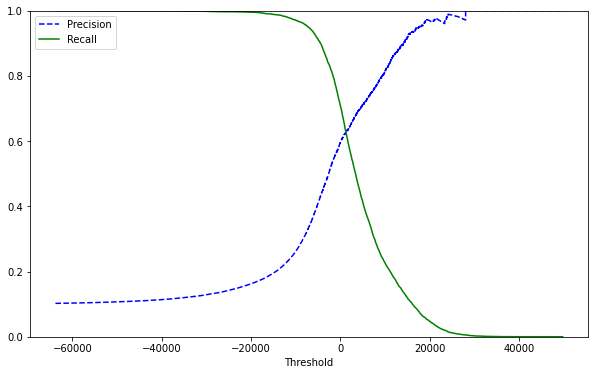

In [34]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

从上图中可以看出，精度曲线比召回率曲线要崎岖一些。原因在于，当你提高阈值时，精度有时也可能会下降（尽管总体趋势是上升的）。另一方面。当阈值上升时，Recall只会下降，这就解释了为什么Recall曲线看起来很平滑。

#### 3. 还有一种找到好的Precision/Recall权衡的方法是直接绘制Precision和Recall的函数图

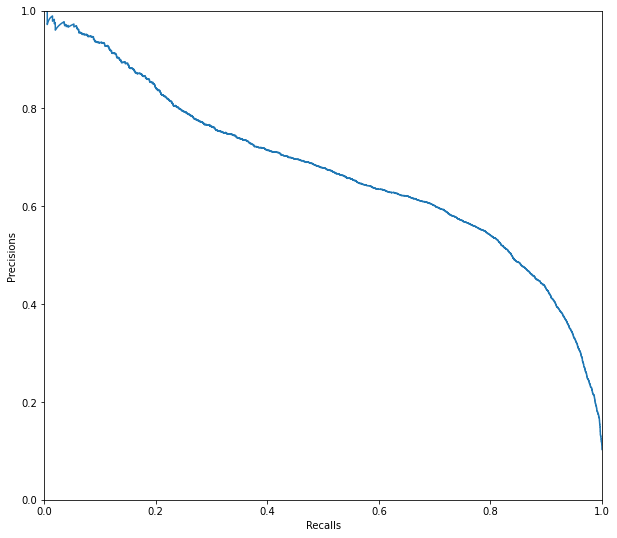

In [35]:
plt.figure(figsize=(10,9))
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recalls")
plt.ylabel("Precisions")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

**由此可见，创建一个你想要的精度的分类器是相当容易的事情：只要阈值足够的高即可！然而，如果召回率太低，精度再高，其实也不怎么有用！如果有人说：“我们需要99%的精度。”你就应该问：“召回率是多少？”**

### ROC曲线
还有一种经常与二元分类器一起使用的工具，叫做**受试者工作特征曲线（简称ROC）**。它与Precision/Recall曲线非常相似，但是绘制的不是Precision和Recall，而是真正类率（召回率的另一名称）和假正类率（FPR）。FPR是被错误分为正类的负类实例比率。它等于1减去真负类率（TNR），后者是被正确分类为负类实例比率，也称为特异度。因此ROC曲线绘制的是灵敏度和（1-特异度）的关系。

[Googl的解释](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=zh-cn)

要绘制ROC曲线，首先需要使用`roc_curve()`函数计算多种阈值的TPR和FPR

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0,1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    

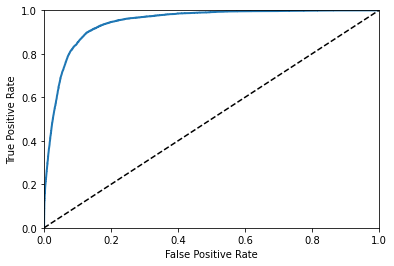

In [38]:
plot_roc_curve(fpr, tpr)
plt.show()

同样这里再次面临一个折中权衡：Recall(TPR)越高，分类器产生的假正类（FPR）就越多。虚线表示随机分类器的ROC曲线：**一个优秀的分类器应该远离这条线越远越好**

一种比较分类器的方法是测量*曲线下面积*（AUC）。完美的分类器的ROC AUC等于1，而纯随机分类器的ROC AUC等于0.5.

Scikit-Learn提供计算ROC AUC的函数-`roc_auc_score()`

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9450408147085357

**由于ROC曲线与Precision/Recall(或PR)曲线非常相似，因此你可能会问如何决定使用哪种曲线。有一个经验法则，当正类非常少见或者你更关注假正类而不是假负类时，你应该选择PR曲线，反之是ROC曲线。**例如，看前面的ROC曲线图，你可能会觉得分类器真不错。但这主要是因为负类（非9）相比，正类（数字9）的数量真的很少。相比之下，PR曲线可以清楚的说明分类器还有改进的空间（曲线还可以更接近右上角）。

**实际上，如果您有一个 AUC 为 1.0 的“完美”分类器，您应该感到可疑，因为这可能表明您的模型中存在错误。例如，您的训练数据可能过拟合，或者带标签数据可能被复制到其中一项特征中。**

**AUC 以相对预测为依据，因此保持相对排名的任何预测变化都不会对 AUC 产生影响。而对其他指标而言显然并非如此，例如平方误差、对数损失函数或预测偏差（稍后讨论）。**

训练一个RandomForestClassifier分类器，并比较它和SGDClassifier分类器的ROC曲线和ROC AUC分数。RandomForestClassifier类没有`decision_function()`方法，但是它有dict_proba()方法。**Scikit-Learn的分类器通常都会有这两种方法中的一种。`dict_proba()`方法返回一个数组，其中每一行为一个实例，每列代表一个类别，意思是给定实例属于给定类别的概率**

In [40]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method='predict_proba')
y_probas_forest

array([[0.98, 0.02],
       [1.  , 0.  ],
       [0.49, 0.51],
       ...,
       [1.  , 0.  ],
       [0.91, 0.09],
       [0.96, 0.04]])

要绘制ROC曲线，需要的是分数值而不是概率大小。一种简单的解决方案是：直接使用正类的概率值作为分数值：

In [41]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)
fpr_forest, tpr_forest, thresholds_forest

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.85010453e-05,
        1.85010453e-05, 3.70020906e-05, 3.70020906e-05, 3.70020906e-05,
        3.70020906e-05, 3.70020906e-05, 3.70020906e-05, 3.70020906e-05,
        5.55031359e-05, 7.40041812e-05, 9.25052265e-05, 9.25052265e-05,
        9.25052265e-05, 9.25052265e-05, 9.25052265e-05, 1.48008362e-04,
        1.48008362e-04, 1.48008362e-04, 1.48008362e-04, 1.48008362e-04,
        1.85010453e-04, 1.85010453e-04, 2.22012544e-04, 2.40513589e-04,
        2.77515680e-04, 3.14517770e-04, 3.33018816e-04, 3.51519861e-04,
        4.81027178e-04, 5.55031359e-04, 5.92033450e-04, 7.21540767e-04,
        7.77043903e-04, 8.51048084e-04, 9.80555401e-04, 1.09156167e-03,
        1.31357422e-03, 1.44308153e-03, 1.59108990e-03, 1.85010453e-03,
        2.12762021e-03, 2.34963275e-03, 2.49764112e-03, 2.793657

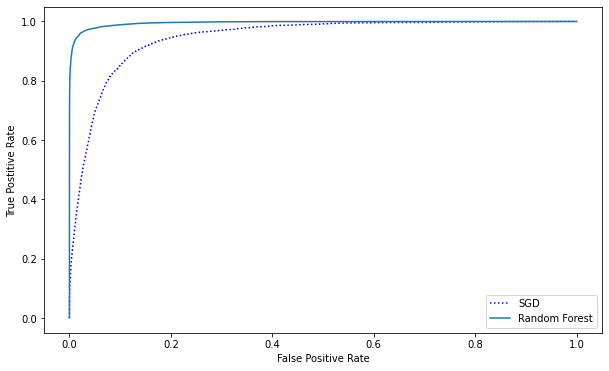

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel('True Postitive Rate')
plt.legend(loc='lower right')
plt.show()

从图中可以看出RandomForestClassifier的ROC曲线比SGDClassifier好的多：它离左上角更接近。因此它的ROC AUC的分数也高的多

In [46]:
roc_auc_score(y_train_9, y_scores_forest)

0.9955051727526318

再测一下precision与recall的得分

In [47]:
y_train_forest_predict = cross_val_predict(forest_clf, X_train, y_train_9, cv=3)
y_train_forest_predict

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

In [48]:
precision_score(y_train_9, y_train_forest_predict)

0.9831207065750736

In [49]:
recall_score(y_train_9, y_train_forest_predict)

0.8419902504622626

可以看到RandomForestClasssifier拥有98.31%的Precision和84.20%的ReCall，也还不错。由于正类9的数量很少，我们应该关注PR曲线，下面把RandomForestClassifier的PR曲线与SGDClassifier的PR曲线绘制在一起看看

In [50]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_9, y_scores_forest)
precisions_forest, recalls_forest, thresholds_forest

(array([0.09915   , 0.1641095 , 0.22085206, 0.27283582, 0.32244565,
        0.3667698 , 0.40843224, 0.44884163, 0.48642403, 0.52177384,
        0.55439093, 0.58344951, 0.61417323, 0.64087367, 0.66727794,
        0.69302326, 0.71604938, 0.73605287, 0.75786988, 0.77604307,
        0.79285616, 0.80903317, 0.82539683, 0.83675866, 0.84808612,
        0.8592919 , 0.86776478, 0.8784375 , 0.88573232, 0.89310785,
        0.90067829, 0.90808163, 0.91555115, 0.9204944 , 0.92689515,
        0.93292371, 0.93755376, 0.94269839, 0.94651   , 0.95047754,
        0.95378301, 0.95574744, 0.95936876, 0.96284093, 0.96639586,
        0.96945427, 0.97162188, 0.97444634, 0.97573094, 0.97782491,
        0.98055231, 0.98312071, 0.98454834, 0.98582551, 0.98810004,
        0.9891925 , 0.99053693, 0.99126092, 0.99180156, 0.9932045 ,
        0.99352751, 0.99431197, 0.99578527, 0.99596503, 0.99614163,
        0.99654696, 0.99696899, 0.99716446, 0.99760019, 0.99755859,
        0.9980139 , 0.99798082, 0.9979445 , 0.99

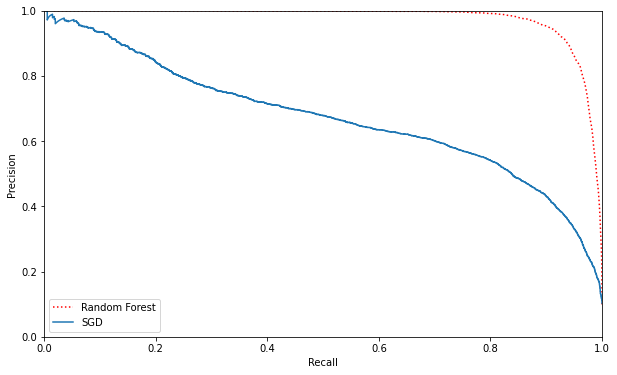

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(recalls_forest[:-1], precisions_forest[:-1], 'r:', label='Random Forest')
plt.plot(recalls[:-1], precisions[:-1], label='SGD')
plt.legend(loc='lower left')
plt.axis([0,1,0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## 多元分类器

### OvA策略
也称为one-versus-the-rest，例如，要创建一个系统将数字图像分为10类（从0到9），一种训练方法是训练10个二元分类器，每个数字一个（0-检测器， 1-检测器， 2-检测器，等等，以此类推）。然后，当你需要对一张图像检测分类时。获取每个分类器的决策分数，那个分类器给分最高，就将其分为那个类。

### OvO策略
为每一个数字训练一个二元分类器：一个用于区分0和1，一个区分0和2，一个区分1和2，以此类推。如果存在N个类别，那么需要训练$N \times (N-1) \div 2$个分类器。对于MNIST问题，这意味着训练45个二元分类器！当需要对一张图片进行分类时，需要运行45个分类器对图片进行分类，最后看那个类别获胜的多。**OvO的主要优点在于，每个分类器只需要用到部分训练集对其必须区分的两个类别进行训练。**

有些算法（例如SVM分类器）在数据规模扩大是表现很糟糕，因此对于这类算法，OvO是一个优先的选择，由于在较小训练集上分别训练多个分类器比在大型数据集上训练少数分类器要快的多。但是对于大多数二元分类器来说，OvA策略还是更好的选择。

Scikit-Learn可以检测到你尝试使用二元分类算法进行多类别分类任务，它会自动运行OvA（SVM分类器除外，它会使用OvO）。

In [57]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([&#39;4&#39;], dtype=&#39;&lt;U1&#39;)

上面的代码看起来非常简单，而在内部，Scikit-Learn实际上训练了10个二元分类器，获得它们对图片的决策分数，然后选择了分数最高的类别

In [58]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-70447.43100346, -18603.88903056, -25498.35295109,
         -2148.1008376 ,  -1640.21582961,  -2561.97569916,
        -44614.56772366, -10441.93373236,  -5217.19704943,
         -2298.91455784]])

In [59]:
np.argmax(some_digit_scores)

4

In [60]:
sgd_clf.classes_

array([&#39;0&#39;, &#39;1&#39;, &#39;2&#39;, &#39;3&#39;, &#39;4&#39;, &#39;5&#39;, &#39;6&#39;, &#39;7&#39;, &#39;8&#39;, &#39;9&#39;], dtype=&#39;&lt;U1&#39;)

In [61]:
sgd_clf.classes_[4]

&#39;4&#39;

**当训练分类器时，目标类别的列表会储存在classes_这个属性中，按值的大小排列**

In [ ]:
如果想要强制Scikit-Learn使用一对一或者一对多的策略，可以使用OneVsOneClassifier或OneVsRestClassifier类

In [62]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([&#39;9&#39;], dtype=object)

In [63]:
len(ovo_clf.estimators_)

45

In [64]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([&#39;9&#39;], dtype=object)

这次Scikit-Learn不必运行OvA或者OvO了，因为Random Forest直接可以将实例分为多个类别。

In [65]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.  , 0.  , 0.06, 0.02, 0.  , 0.02, 0.01, 0.89]])

要评估这些分类器，使用交叉验证，我们可以使用`cross_val_score()`函数评估一下SGDClassifier的准确率

In [66]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88005, 0.8818 , 0.86965])

所有的测试折叠上都超过了86%，如果是一个随机分类器，准确率大概是10%，所以这个结果不是太糟，但是依然有提升的空间。例如，将输入进行简单的缩放，可以将准确率提升到90%以上

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.89575, 0.89875, 0.90535])

## 错误分析
在这里，假设你已经找到了一个潜力的模型，现在你希望找到一些方法对其进一步改进，方法之一就是分析其错误类型。


### 首先，看看混淆矩阵

In [68]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5592,    0,   14,    9,    9,   44,   27,    4,  223,    1],
       [   1, 6413,   43,   19,    3,   45,    5,    7,  196,   10],
       [  26,   28, 5237,   87,   72,   25,   64,   40,  368,   11],
       [  26,   23,  117, 5217,    0,  208,   24,   41,  407,   68],
       [  11,   14,   45,   11, 5247,    9,   31,   16,  310,  148],
       [  30,   17,   25,  163,   52, 4467,   80,   16,  504,   67],
       [  28,   17,   51,    1,   39,   89, 5547,    4,  142,    0],
       [  17,   12,   55,   23,   46,   12,    5, 5714,  174,  207],
       [  17,   69,   35,   91,    3,  125,   31,    6, 5430,   44],
       [  21,   23,   32,   60,  117,   34,    1,  169,  359, 5133]])

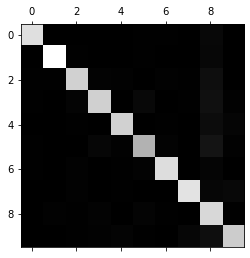

In [69]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

将混淆矩阵中的每个值除以相应类别中的图片的数量，这样比较的是错误率而不是错误的绝对值：

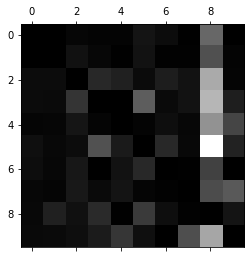

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

每行代表实际类别，而每列表示预测类别。第8列和第9列整体看起来很亮，说明有许多图片被错误地分类为数字8或数字9了。同样类别8和类别9的行看起来很亮，说明数字8和数字9经常会跟其他数字混淆。相反一些行很暗，比如行1，这意味着大多数数字1都被正确地分类（有一些与数字8弄混了而已，但仅此而已）。注意。错误不是完全对称的，比如，数字5被错分为数字8的数量比数字8被错分为数字5的数量要多。

分析混淆矩阵通常可以帮助你深入了解如何改进分类器。通过上图，你的精力可以花在改进数字8和数字9的分类，以及修正数字3和数字5的混淆上。例如，可以试着收集更多这些数字的训练数据。或者，也可以开发一些新特征来改进分类器——例如可以写一个算法来计算闭环的数量，在或者，还可以对图片进行预处理（例如，使用Scikit-Image, Pillow或OpenCV）让某些模式更为突出，比如闭环之类。

分析单个错误也可以为分类器提供洞察：它在做什么？它为什么失败？但这通常更加困难和耗时。例如，我们来看看数字3和数字5的例子：

In [74]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

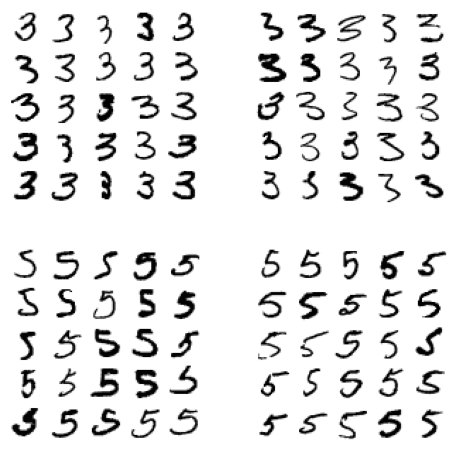

In [76]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

分类器在左下方和右上方的矩阵里弄错了数字，原因在于，我们使用的简单的SGDClassifier模型是一个线性模型。它所做的就是为每一个像素分配一个各个类别的权重，当他看到新的图像时，将加权后的像素强度汇总，从而得到一个分数进行分类。而数字3和数字5只在一部分像素上有区别，所以分类器很容易将其弄混。

数字3和数字5之间的主要区别是在于连接顶线和下方弧线的中间那段小线条的位置。如果您写的数字3将连接点略往左移，分类器就可能将其分类为数字5，反之亦然。换言之，这个分类器对图像位移和旋转非常敏感。因此，减少数字3和数字5混淆的方法之一，就是对图片进行预处理，确保他们位于中心位置并且没有旋转。这同样有助于减少其他的错误。

## 多标签分类
分类器为每个实例产出多个类别

In [78]:
from sklearn.neighbors import KNeighborsClassifier
y_train_num = y_train.astype(np.uint8)
y_train_large = (y_train_num >= 7)
y_train_large

array([False, False,  True, ..., False, False, False])

In [79]:
y_train_odd = (y_train_num % 2 == 1)
y_train_odd

array([False, False,  True, ...,  True, False, False])

In [80]:
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False, False],
       [False, False],
       [ True,  True],
       ...,
       [False,  True],
       [False, False],
       [False, False]])

In [81]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [82]:
knn_clf.predict([some_digit])

array([[ True,  True]])

评估多标签分类器的方法很多，如何选择正确的度量指标取决于你的项目。比如方法之一是测量每个标签的$F_1$分数，然后简单的平均。

In [83]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train,y_train_knn_pred, average='macro')

0.9677291043813279

这里假设所有的标签同等重要，但实际上是不可能的。特别是，如果训练的照片里爱丽丝比鲍勃和查理都要多得多，你可能想给区分爱丽丝的分类器更高的权重。一个简单的方法是给每个标签设置一个等于其自身支持的权重（也就是具有该目标标签的示例的数量）。只需要在上面的代码中设置`average="weighted"`即可

## 多输出分类
**多输出-多类别分类**是多标签的泛化，其标签也可以是多种类别的（比如它可以有两个以上可能的值）。

为了说明这个问题，构建一个系统去除图片中的噪声。给它输入一张有噪声的图像，他将输出一张干净的图像，跟其他的MNIST图像一样，以像素强度的一个数组做出呈现方式。**请注意，这个分类器的输出是多个标签（一个像素点一个标签），每个标签可以有多个值（像素强度范围为0到255）。所以这是个多输出分类系统的例子**

**PS:分类和回归之前的界限有时很模糊，比如这个例子。可以说，预测像素强度更像是一个回归任务而不是分类任务。而多输出系统也不仅仅限于分类任务，可以让一个系统给每个实例输出多个标签，同时包括类别标签和值标签。**

In [86]:
# 创建训练集和测试集
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test


In [92]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[15]])

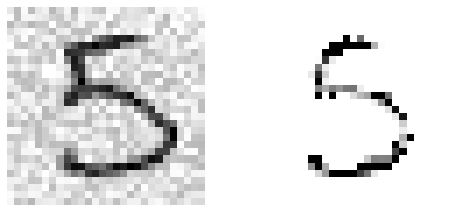

In [98]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits([X_test_mod[15]])
plt.subplot(222); plot_digits(clean_digit)